In [20]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torchvision import datasets, transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import os
from model import CNN

In [21]:
# Hyper param
epoch_num = 60
batch_size = 128
lr = 1e-4
class_num = 7

# Dataset preprocessing

In [22]:
# Read data (48x48 pixel gray scale images)
# Dataset link: https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer
train_dir = '../../data/emotion-detection/train'
test_dir = '../../data/emotion-detection/test'

transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(0.5, 0.5)])

train_dataset = datasets.ImageFolder(train_dir,transform=transform)
test_dataset = datasets.ImageFolder(test_dir,transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print(train_dataset.class_to_idx)
print(test_dataset.class_to_idx)

{'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}
{'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}


## Test the dataloader

torch.Size([1, 48, 48])


Text(0.5, 1.0, 'fearful')

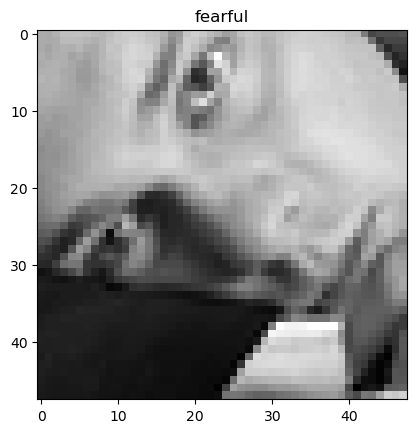

In [23]:
testdata = next(iter(train_loader))
pic = testdata[0][0]
print(pic.size())
label = testdata[1][0]

idx_to_class = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
plt.imshow(np.reshape(pic, pic.size()[1:]), cmap='gray')
plt.title(idx_to_class[label])

# Components

In [24]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = CNN(class_num).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
torch.cuda.is_available()

True

# Countinue training from checkpoint

In [25]:
train_loss_list = []
val_loss_list = []
resume_epoch = 0

In [26]:
try:
    most_recent_check_point = os.listdir('checkpoint')[-1]
    ckpt_path = os.path.join('checkpoint', most_recent_check_point)
    check_point = torch.load(ckpt_path)
    # load model
    model.load_state_dict(check_point['state_dict'])
    resume_epoch = check_point['epoch']
    train_loss_list = check_point['train_loss_list']
    val_loss_list = check_point['val_loss_list']
    print(f'Successfully load checkpoint {most_recent_check_point}, '
          f'start training from epoch {resume_epoch + 1}')
    plt.plot(train_loss_list, label='train')
    plt.plot(val_loss_list, label='validation')
    plt.title("Loss")
    plt.legend()
    plt.show()
except:
    print('fail to load checkpoint, train from zero beginning')

for _ in range(resume_epoch):
    scheduler.step()

fail to load checkpoint, train from zero beginning


# Training

In [27]:
for epoch in range(resume_epoch + 1, epoch_num):
    for i, (pics, labels) in enumerate(train_loader):
        pics = pics.to(device)
        labels = labels.to(device)
        output = model(pics)
        loss = criterion(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss_list.append(loss.item())
    with torch.no_grad():
        val_pics, val_labels = next(iter(test_loader))
        val_pics = val_pics.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_pics)
        val_loss = criterion(val_output, val_labels)
        val_loss_list.append(val_loss.item())


    print(
        f'Epoch: {epoch} / {epoch_num}\t'
        f'train_loss: {train_loss_list[-1]:.8f}\t'
        f'val_loss: {val_loss_list[-1]:.8f}\t'
        f'lr: {optimizer.state_dict()["param_groups"][0]["lr"]:.8f}\t'
    )

    scheduler.step()

    # save ckpt
    if epoch % 10 == 0:
        os.makedirs('checkpoint', exist_ok=True)
        torch.save({'epoch': epoch,
                    'state_dict': model.state_dict(),
                    'train_loss_list': train_loss_list,
                    'val_loss_list': val_loss_list,
                    }, f'checkpoint/{epoch:03d}.pt')

D:\PythonWorkspace\Projects\ML\Practice\Emotion Detection\model.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.output(out)


Epoch: 1 / 60	train_loss: 1.88476956	val_loss: 1.84401608	lr: 0.00010000	
Epoch: 2 / 60	train_loss: 1.84653556	val_loss: 1.87011707	lr: 0.00009800	
Epoch: 3 / 60	train_loss: 1.67538393	val_loss: 1.78336203	lr: 0.00009604	
Epoch: 4 / 60	train_loss: 1.71857715	val_loss: 1.81598496	lr: 0.00009412	
Epoch: 5 / 60	train_loss: 1.86690950	val_loss: 1.75550580	lr: 0.00009224	
Epoch: 6 / 60	train_loss: 1.80496478	val_loss: 1.81130207	lr: 0.00009039	
Epoch: 7 / 60	train_loss: 1.83075178	val_loss: 1.77373767	lr: 0.00008858	
Epoch: 8 / 60	train_loss: 1.60523617	val_loss: 1.76708603	lr: 0.00008681	
Epoch: 9 / 60	train_loss: 1.65017068	val_loss: 1.74913847	lr: 0.00008508	
Epoch: 10 / 60	train_loss: 1.67883551	val_loss: 1.67369926	lr: 0.00008337	
Epoch: 11 / 60	train_loss: 1.73019755	val_loss: 1.68186414	lr: 0.00008171	
Epoch: 12 / 60	train_loss: 1.60569620	val_loss: 1.74122453	lr: 0.00008007	
Epoch: 13 / 60	train_loss: 1.68515790	val_loss: 1.69609022	lr: 0.00007847	
Epoch: 14 / 60	train_loss: 1.65050

# Draw loss curve

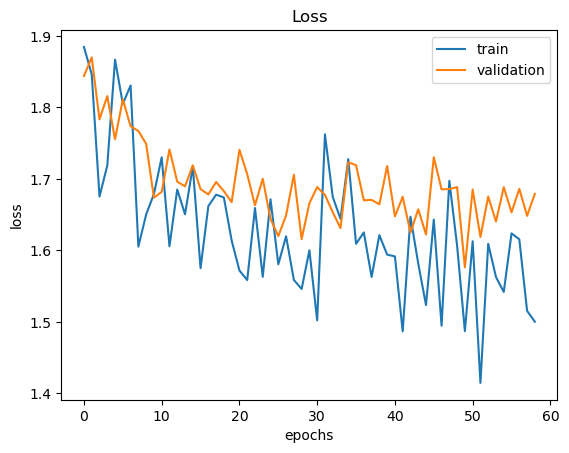

In [28]:
plt.plot(train_loss_list, label='train')
plt.plot(val_loss_list, label='validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss')
plt.legend()

# Test the model

In [29]:
with torch.no_grad():
    correct = 0
    total = 0
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        output = model(imgs)

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f'Accuracy: {correct / total}')

Accuracy: 0.505293953747562


# Save model

In [30]:
torch.save(model, 'model.pth')